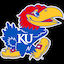

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_64x64x3.jpg")

with Image.open(filename, "r") as im:
    display(im)

# True for noisy execution, False for noise_free execution
noisy_execution = False
draw_qc = True


In [2]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))
        
def display_matrix(matrix):
    try:
        display(Matrix(matrix))
    except:
        print(matrix)


In [3]:
from qcc.filters import *

stride = 1
kernel_raw = avg_filter(4, dim = 2)
# kernel_raw = sobel_filter(3, axis=0)
# kernel_raw = laplacian_approx(3)
# kernel_raw = gaussian_blur(3)

npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in kernel_raw.shape)
kernel = np.pad(kernel_raw, pad_width=npad, mode="constant", constant_values=0)

display_matrix(kernel)


Matrix([
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625]])

In [4]:
from qcc.quantum import flatten_image, normalize, to_qubits
from qcc.filters import update_dims

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

dims_q = [to_qubits(x) for x in dims]
dims_out = update_dims(dims, kernel_size=kernel_raw.shape, stride=stride)

num_qubits = sum(dims_q)
num_states = 2**num_qubits

print(dims_out, mag)


(61, 61, 3) 14051.205784558135


/Users/mingyoungjeng/Documents/repos.nosync/quantum-convolutional-classifier/.env/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


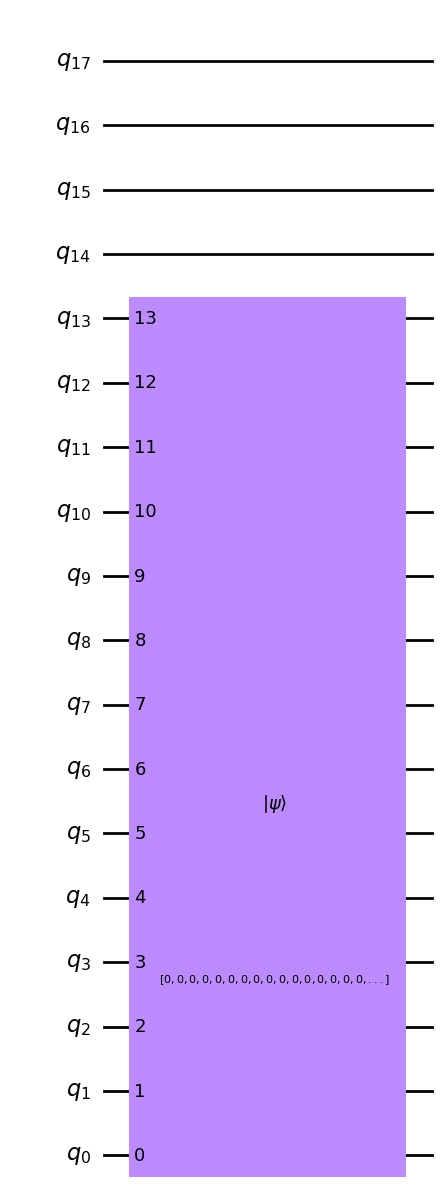

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

kernel_shape_q = [int(np.ceil(np.log2(filter_size))) for filter_size in kernel.shape]
num_ancilla = sum(kernel_shape_q)
total_qubits = num_qubits + num_ancilla

qc = QuantumCircuit(total_qubits)
qc.initialize(psi, qc.qubits[:-num_ancilla])

display_quantum_circuit(qc)


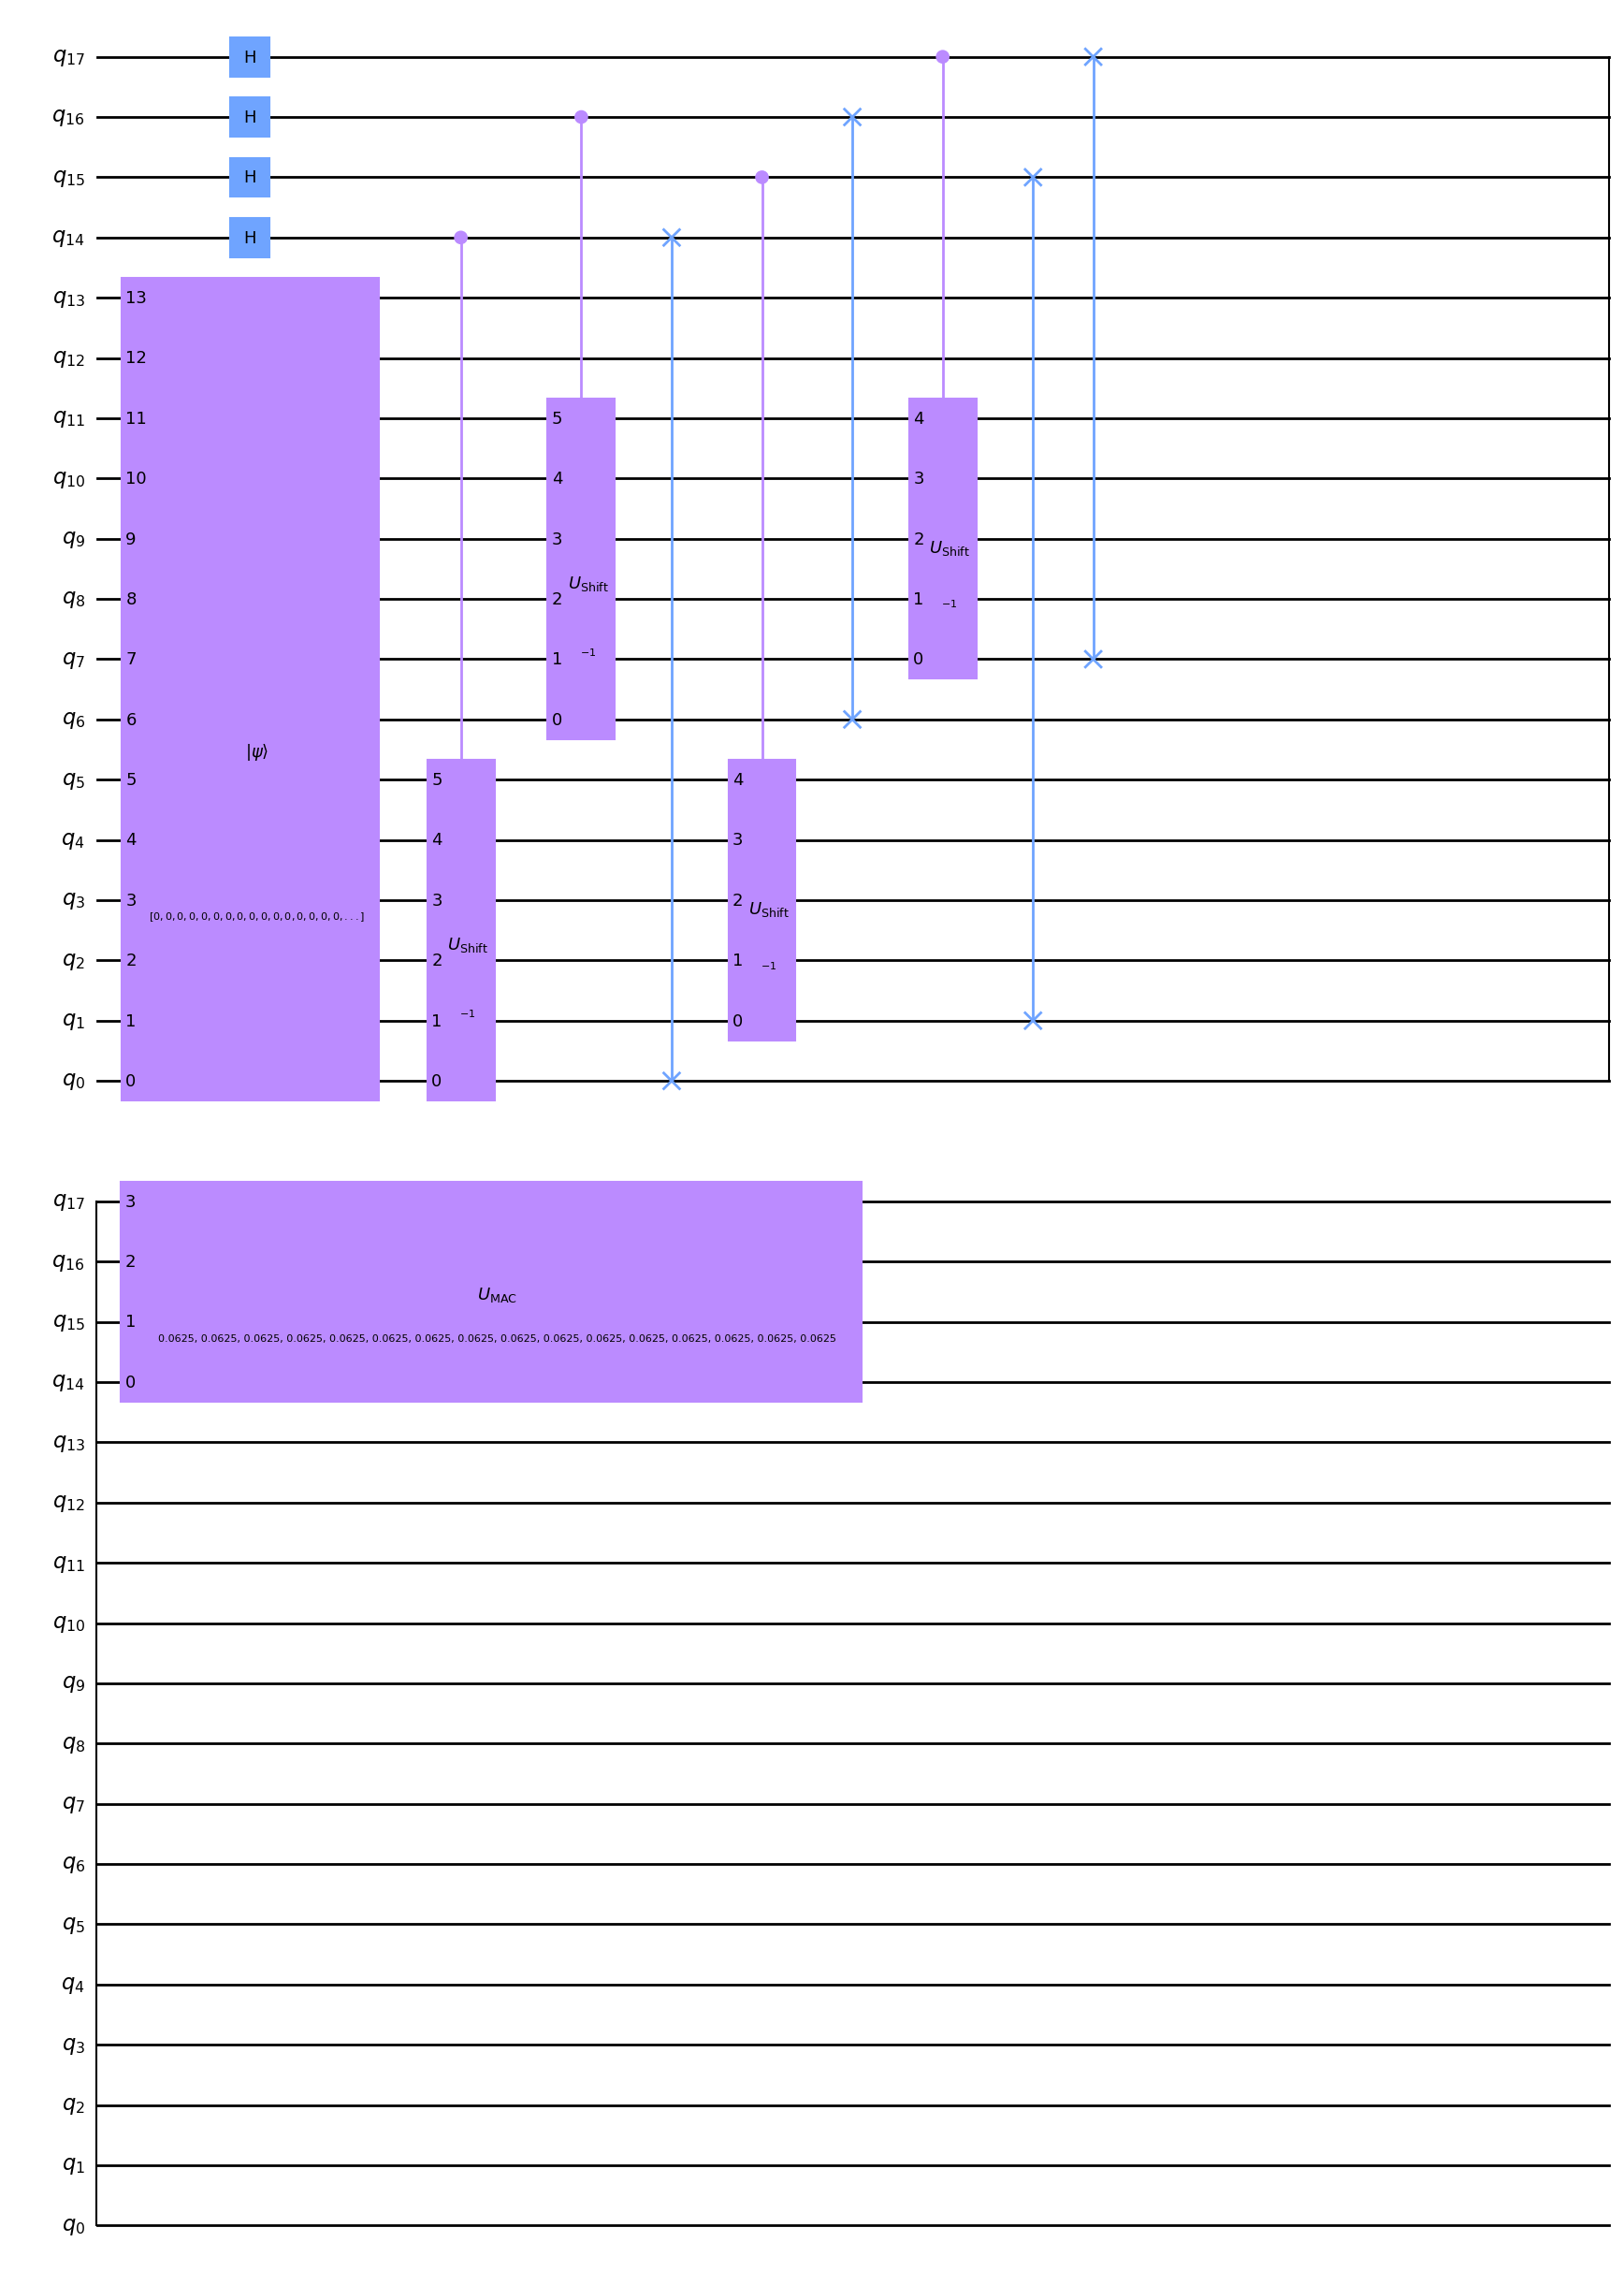

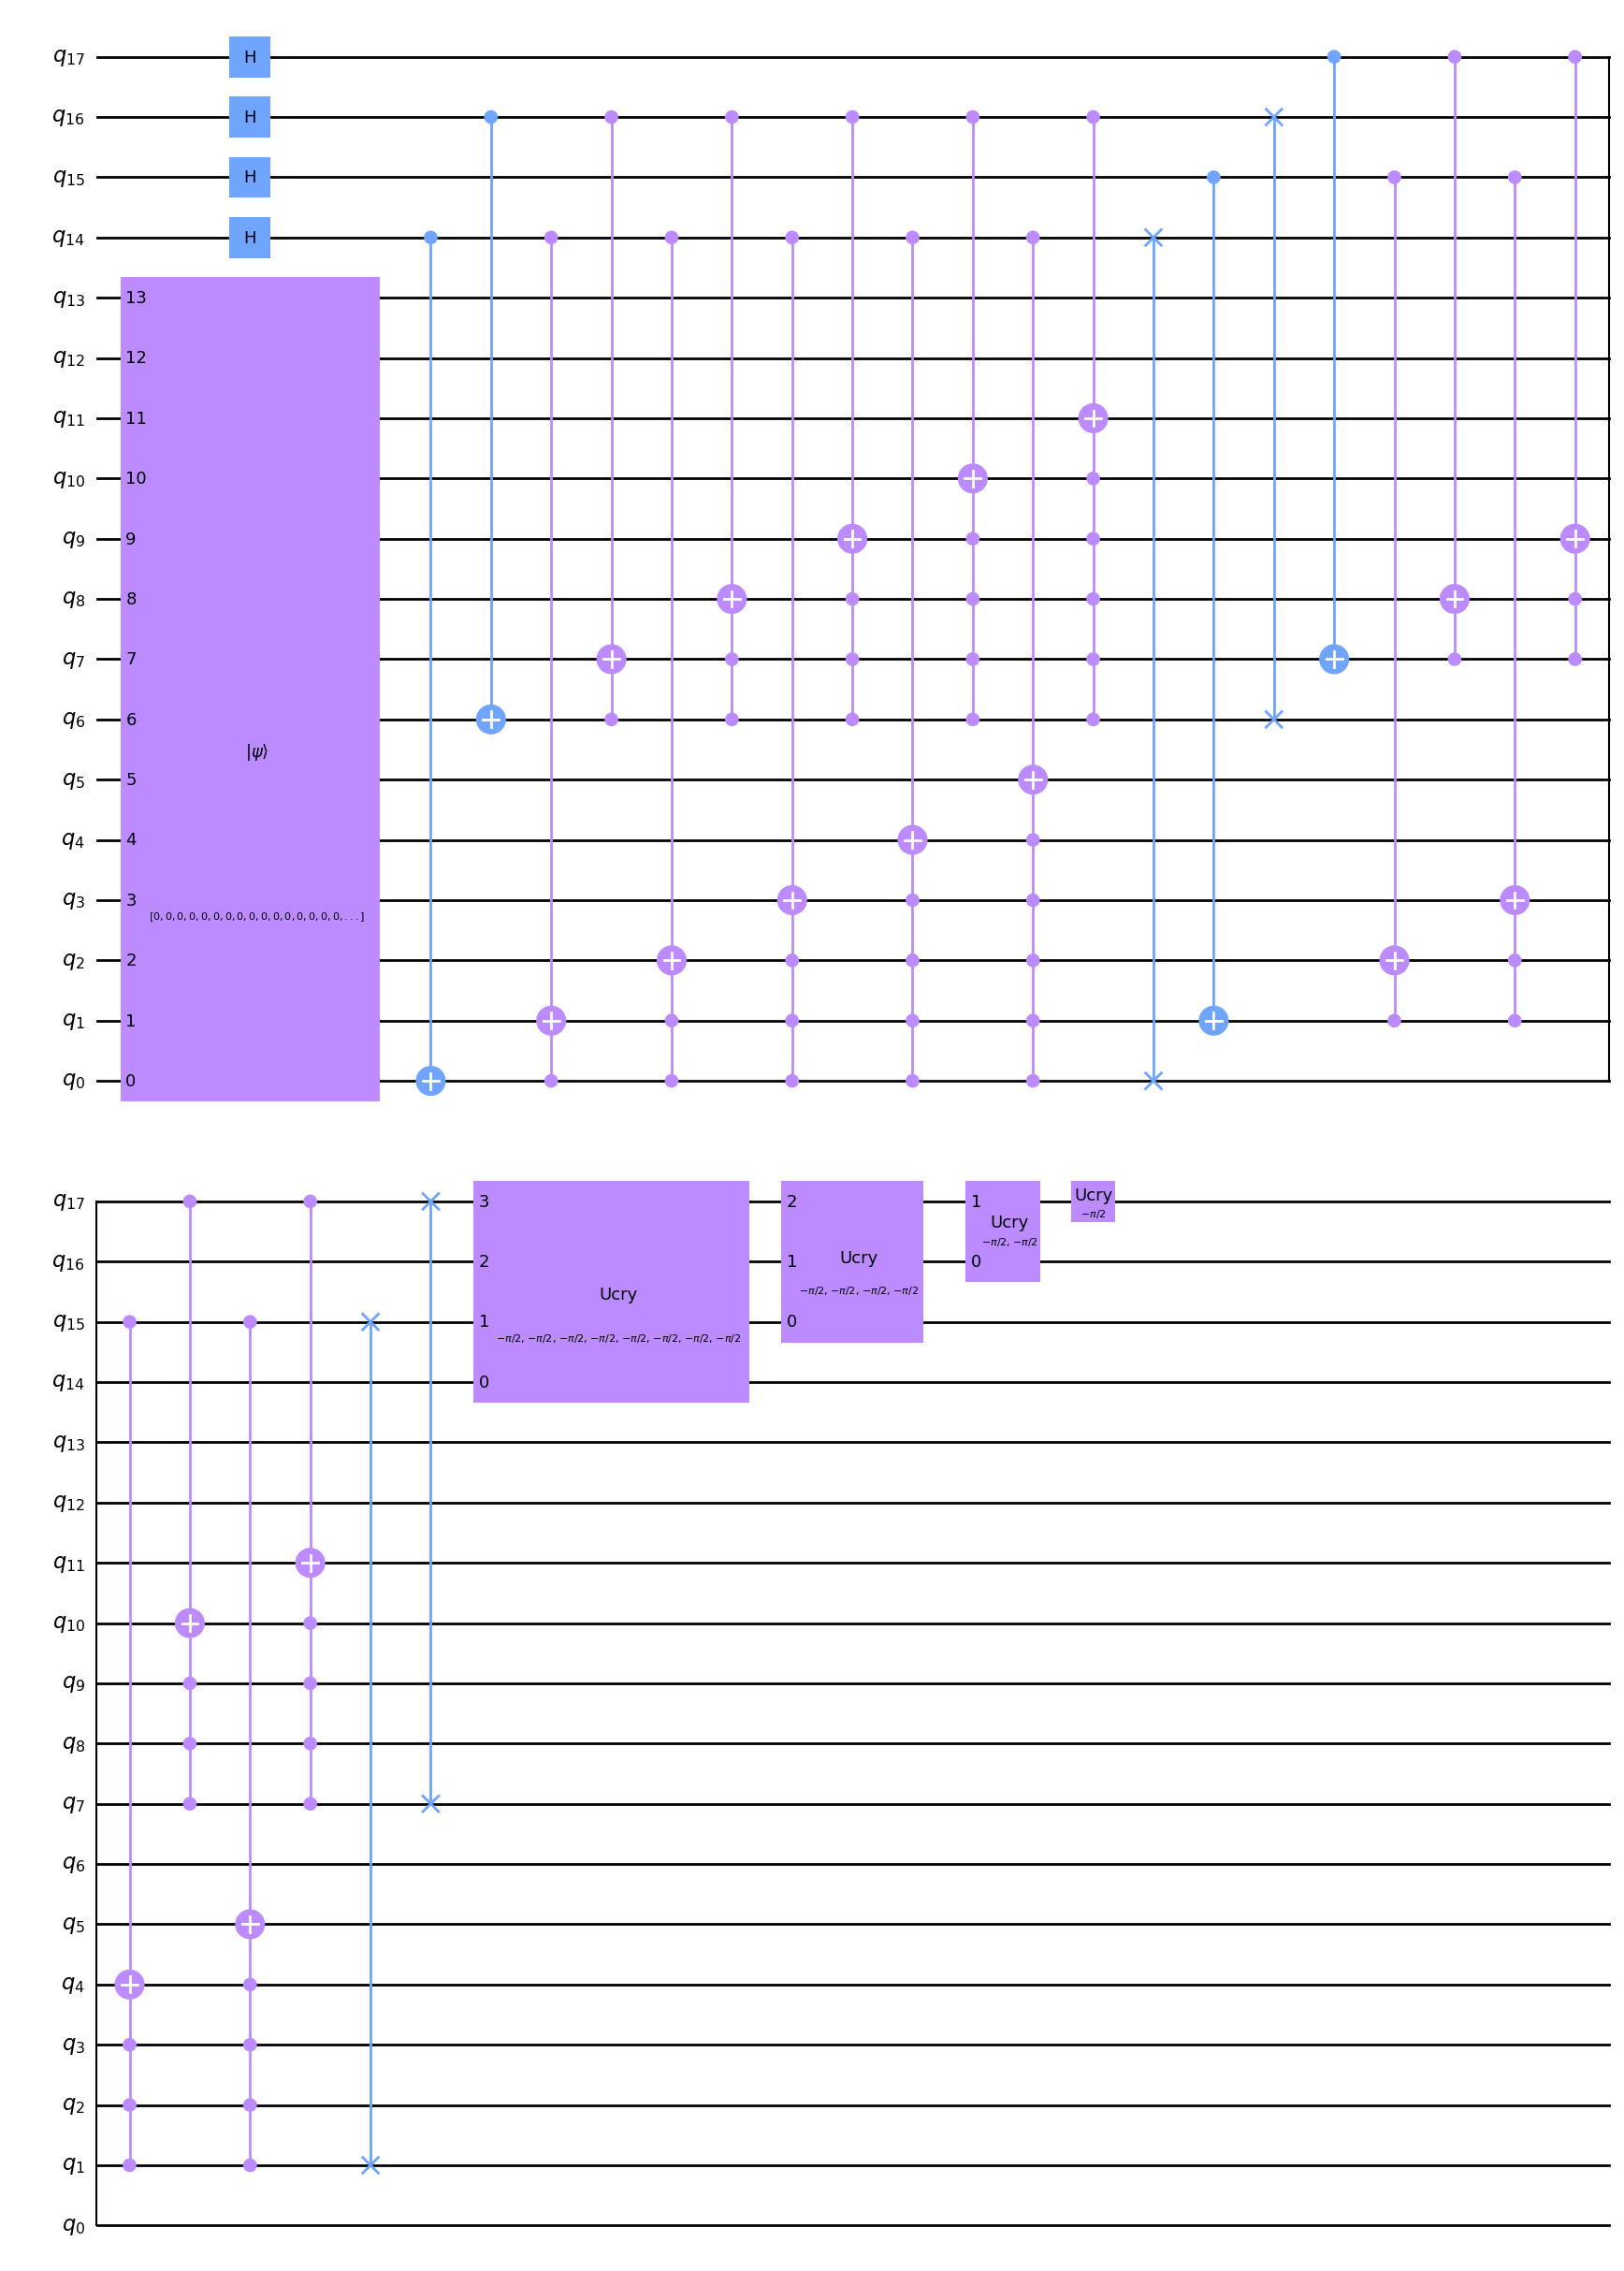

In [6]:
from qcc.quantum.qiskit import Convolution

conv = Convolution(dims, kernel)
kernel_mag = conv.kernel_norm
qc.compose(conv, inplace=True)

display_quantum_circuit(qc.decompose(Convolution))
display_quantum_circuit(qc.decompose([Convolution, "shift", "MAC"], reps=2))

In [7]:
from qcc.quantum.qiskit import potato

psi_out = potato(qc, noisy_execution=noisy_execution)

0.0 254.93750000000006


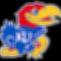

In [8]:
from qcc.quantum import reconstruct

i = 0
img = psi_out.data[i*num_states:(i+1)*num_states]
norm = mag * kernel_mag * np.sqrt(2**num_ancilla)

print(min(np.abs(norm*img)), max(np.abs(norm*img)))

img = reconstruct(norm*img, dims, dims_out)
img = Image.fromarray(np.abs(img).astype(np.uint8))
img.save("output.png")

display(img)


### Classical Results

In [9]:
display_matrix(kernel_raw)


Matrix([
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625],
[0.0625, 0.0625, 0.0625, 0.0625]])

(61, 61, 3) 0.0 254.9375


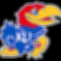

In [10]:
with Image.open(filename, "r") as im:
    image_data = np.asarray(im, dtype=float)

classical_img = convolution(image_data, kernel_raw, stride=stride)

print(classical_img.shape, min(classical_img.flatten()), max(classical_img.flatten()))

classical_img = classical_img.astype(np.uint8)
classical_img = Image.fromarray(classical_img)
display(classical_img)
classical_img.save("output_classical.png")


In [11]:
from qcc.quantum import get_fidelity

fid = get_fidelity(np.asarray(classical_img).flatten(), np.asarray(img).flatten())

print(f"Fidelity: {fid:.03%}")


Fidelity: 100.000%
